In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import ta   
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, classification_report, PrecisionRecallDisplay, roc_curve, precision_recall_curve, average_precision_score 
)
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline, make_pipeline
from sklearn import metrics, pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Для XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
ticker = 'BTC-USD'
start_date = '2022-07-10'
end_date = pd.to_datetime('today').strftime('2025-07-10')

In [3]:
print(f"Загрузка данных для {ticker} с {start_date} по {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)
print("Данные загружены.")
print(df.head())
print(df.info())

Загрузка данных для BTC-USD с 2022-07-10 по 2025-07-10...


C:\Users\user\AppData\Local\Temp\ipykernel_8884\323453866.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Данные загружены.
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-10  20860.449219  21591.080078  20727.123047  21591.080078   
2022-07-11  19970.556641  20856.353516  19924.539062  20856.353516   
2022-07-12  19323.914062  20043.445312  19308.531250  19970.474609   
2022-07-13  20212.074219  20223.052734  18999.953125  19325.972656   
2022-07-14  20569.919922  20789.894531  19689.257812  20211.466797   

Price            Volume  
Ticker          BTC-USD  
Date                     
2022-07-10  28688807249  
2022-07-11  24150249025  
2022-07-12  25810220018  
2022-07-13  33042430345  
2022-07-14  31158743333  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-07-10 to 2025-07-09
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -

In [4]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

In [5]:
print(df.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-10  20860.449219  21591.080078  20727.123047  21591.080078   
2022-07-11  19970.556641  20856.353516  19924.539062  20856.353516   
2022-07-12  19323.914062  20043.445312  19308.531250  19970.474609   
2022-07-13  20212.074219  20223.052734  18999.953125  19325.972656   
2022-07-14  20569.919922  20789.894531  19689.257812  20211.466797   

Price            Volume  
Ticker          BTC-USD  
Date                     
2022-07-10  28688807249  
2022-07-11  24150249025  
2022-07-12  25810220018  
2022-07-13  33042430345  
2022-07-14  31158743333  


In [6]:
price_col = 'Close'

In [7]:
df['Log_Return'] = np.log(df[price_col] / df[price_col].shift(1))

In [8]:
df['Log_Return'].dropna()

Date
2022-07-11   -0.043596
2022-07-12   -0.032916
2022-07-13    0.044937
2022-07-14    0.017550
2022-07-15    0.012868
                ...   
2025-07-05    0.001820
2025-07-06    0.009205
2025-07-07   -0.008571
2025-07-08    0.005988
2025-07-09    0.021576
Name: Log_Return, Length: 1095, dtype: float64

In [9]:
df['Log_Return'].max()

0.11461585743295792

In [10]:
window_size_vol = 20

In [11]:
df['Rolling_Volatility'] = df['Log_Return'].rolling(window=window_size_vol).std() * np.sqrt(365)

In [12]:
print(df['Rolling_Volatility'].isnull().sum())

20


In [13]:
df.dropna(inplace=True)

In [14]:
df['Rolling_Volatility'].mean()

0.4680869383754888

In [15]:
volatility_threshold = df['Rolling_Volatility'].quantile(0.90) # 90-й перцентиль
print(f"\nПорог всплеска волатильности (90-й перцентиль): {volatility_threshold:.4f}")


Порог всплеска волатильности (90-й перцентиль): 0.7040


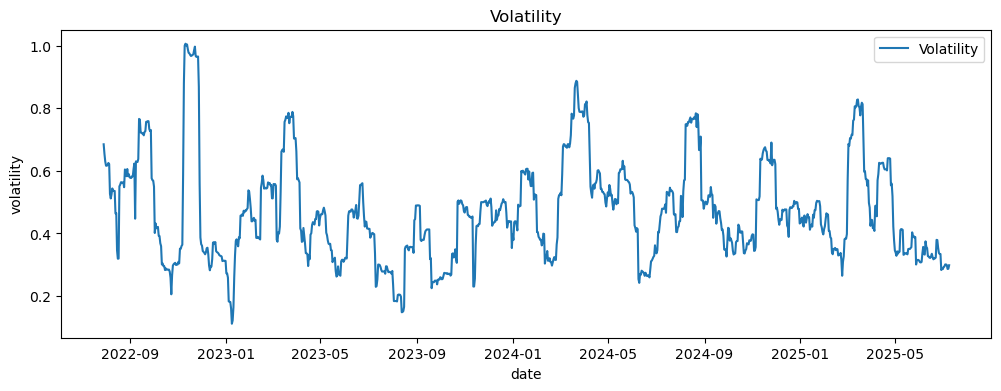

In [16]:
plt.figure(figsize=(12, 4)) 
plt.plot(df['Rolling_Volatility'], label="Volatility")
plt.title('Volatility') 
plt.xlabel("date")
plt.ylabel("volatility") 
plt.legend() 
plt.show()

In [17]:
#создание целевого признака
df['Target_Volatility_Spike'] = (df['Rolling_Volatility'].shift(-1) > volatility_threshold).astype(int)

In [18]:
df.head(3)

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-07-30  23656.207031  24572.580078  23580.507812  23796.818359   
2022-07-31  23336.896484  24121.642578  23275.703125  23652.070312   
2022-08-01  23314.199219  23464.787109  22890.796875  23336.718750   

Price            Volume Log_Return Rolling_Volatility Target_Volatility_Spike  
Ticker          BTC-USD                                                        
Date                                                                           
2022-07-30  28148218301  -0.006255           0.684976                       0  
2022-07-31  23553591896  -0.013590           0.654304                       0  
2022-08-01  25849159141  -0.000973           0.629904                       0

In [19]:
print(f"Размер датафрейма после базовой подготовки: {df.shape}")
print("\nРаспределение целевой переменной:")
print(df['Target_Volatility_Spike'].value_counts(normalize=True))

Размер датафрейма после базовой подготовки: (1076, 8)

Распределение целевой переменной:
Target_Volatility_Spike
0    0.899628
1    0.100372
Name: proportion, dtype: float64


In [20]:
print("\nШаг 1: Создание ценовых признаков")
# Лагированные логарифмические доходности
for i in [1, 2, 3, 5, 10]: # Лаги за 1, 2, 3, 5, 10 дней(смещения)
    df[f'Log_Return_lag_{i}'] = df['Log_Return'].shift(i)


Шаг 1: Создание ценовых признаков


In [21]:
# Дневной диапазон относительно цены закрытия
df['Daily_Range_Ratio'] = (df['High'] - df['Low']) / df['Close']

In [22]:
# Разрывы (Gaps) - насколько цена открытия текущего дня отличается от закрытия предыдущего
df['Open_Prev_Close_Gap_Ratio'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

In [23]:
# Относительное положение цены закрытия в дневном диапазоне
# 0 = закрытие на минимуме, 1 = закрытие на максимуме
df['Close_Position_in_Range'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

In [24]:
# Обработка деления на ноль, если High == Low
df['Close_Position_in_Range'].fillna(0.5, inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_8884\1609063150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_Position_in_Range'].fillna(0.5, inplace=True)


In [25]:
# Отношение цены закрытия к открытию
df['Close_Open_Ratio'] = df['Close'] / df['Open']

In [26]:
print("Ценовые признаки созданы.")
df.dropna(inplace=True)
df.head()

Ценовые признаки созданы.


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2022-08-09  23164.318359  23898.615234  22982.000000  23811.484375   
2022-08-10  23947.642578  24127.414062  22771.519531  23162.898438   
2022-08-11  23957.529297  24822.628906  23900.996094  23948.345703   
2022-08-12  24402.818359  24412.566406  23657.265625  23957.203125   
2022-08-13  24424.068359  24860.050781  24346.115234  24402.187500   

Price            Volume Log_Return Rolling_Volatility Target_Volatility_Spike  \
Ticker          BTC-USD                                                         
Date                                                                            
2022-08-09  23555719219  -0.027471           0.525127                       0   
2022-08-10  32837431722   0.033257           0.543867                       0   
2022-08-11  37127036580   0.000413           0.535490                       0   
2022-08-12  27265804688   0.018416           0.535793                       0   
2022-08-13  22987346289   0.000870           0.535867                       0   

Price      Log_Return_lag_1 Log_Return_lag_2 Log_Return_lag_3  \
Ticker                                                          
Date                                                            
2022-08-09         0.026972         0.009303        -0.014185   
2022-08-10        -0.027471         0.026972         0.009303   
2022-08-11         0.033257        -0.027471         0.026972   
2022-08-12         0.000413         0.033257        -0.027471   
2022-08-13         0.018416         0.000413         0.033257   

Price      Log_Return_lag_5 Log_Return_lag_10 Daily_Range_Ratio  \
Ticker                                                            
Date                                                              
2022-08-09        -0.009480         -0.006255          0.039570   
2022-08-10         0.028676         -0.013590          0.056619   
2022-08-11        -0.014185         -0.000973          0.038469   
2022-08-12         0.009303         -0.014520          0.030951   
2022-08-13         0.026972         -0.005744          0.021042   

Price      Open_Prev_Close_Gap_Ratio Close_Position_in_Range Close_Open_Ratio  
Ticker                                                                         
Date                                                                           
2022-08-09                  0.000084                0.198904         0.972821  
2022-08-10                 -0.000061                0.867415         1.033879  
2022-08-11                  0.000029                0.061340         1.000383  
2022-08-12                 -0.000014                0.987094         1.018600  
2022-08-13                 -0.000026                0.151679         1.000897

In [27]:
print("\nШаг 2: Создание признаков, связанных с объёмом")


Шаг 2: Создание признаков, связанных с объёмом


In [28]:
# Лагированные объёмы
for i in [1, 2, 3, 5, 10]:
    df[f'Volume_lag_{i}'] = df['Volume'].shift(i)

In [29]:
# Показывает, насколько текущий объем выше/ниже среднего
volume_ma_window = 20
df['Volume_MA'] = df['Volume'].rolling(window=volume_ma_window).mean()

In [30]:
df.columns = df.columns.droplevel(1)

In [31]:
# Отношение текущего объёма к скользящему среднему объёма
df['Volume_to_MA_Ratio'] = df['Volume'] / df['Volume_MA']

In [32]:
# Изменение объёма относительно предыдущего дня
df['Volume_Daily_Change_Ratio'] = (df['Volume'] - df['Volume'].shift(1)) / df['Volume'].shift(1)

In [33]:
print("\n--- Шаг 3: Создание признаков, связанных с волатильностью ---")


--- Шаг 3: Создание признаков, связанных с волатильностью ---


In [34]:
# Лагированная скользящая волатильность
for i in [1, 2, 3, 5, 10]:
    df[f'Rolling_Volatility_lag_{i}'] = df['Rolling_Volatility'].shift(i)

In [35]:
# Изменение скользящей волатильности относительно предыдущего дня
df['Rolling_Volatility_Daily_Change_Ratio'] = (df['Rolling_Volatility'] - df['Rolling_Volatility'].shift(1)) / df['Rolling_Volatility'].shift(1)

In [36]:
# Отношение краткосрочной волатильности к долгосрочной
short_vol_window = 10
long_vol_window = 50
df['Short_Term_Volatility'] = df['Log_Return'].rolling(window=short_vol_window).std() * np.sqrt(365)
df['Long_Term_Volatility'] = df['Log_Return'].rolling(window=long_vol_window).std() * np.sqrt(365)
df['Vol_Ratio_Short_Long'] = df['Short_Term_Volatility'] / df['Long_Term_Volatility']

In [37]:
print("\n--- Шаг 4: Создание технических индикаторов ")


--- Шаг 4: Создание технических индикаторов 


In [38]:
# Relative Strength Index (RSI)
rsi_indicator = ta.momentum.RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi_indicator.rsi()

In [39]:
indic = ta.wrapper.StochasticOscillator

In [40]:
# Moving Average Convergence Divergence (MACD)
macd_indicator = ta.trend.MACD(close=df[price_col], window_fast=12, window_slow=26, window_sign=9)
df['MACD'] = macd_indicator.macd()
df['MACD_Signal'] = macd_indicator.macd_signal()
df['MACD_Diff'] = macd_indicator.macd_diff() # Отклонение MACD от сигнальной линии

In [41]:
# Bollinger Bands (BB)
bb_band = ta.volatility.BollingerBands(close=df[price_col], window=20, window_dev=2)
df['BB_Upper'] = bb_band.bollinger_hband()
df['BB_Lower'] = bb_band.bollinger_lband()
df['BB_Width'] = bb_band.bollinger_wband()
df['BB_Percent'] = bb_band.bollinger_pband()

In [42]:
# KeltnerChannel
KeltnerChannel = ta.volatility.KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], original_version=True, window=20, window_atr=10, multiplier=2)
df['KC_high'] = KeltnerChannel.keltner_channel_hband()
df['KC_low'] = KeltnerChannel.keltner_channel_lband()
df['KC_mid'] = KeltnerChannel.keltner_channel_mband()
df['KC_Percent'] = KeltnerChannel.keltner_channel_pband()

In [43]:
#UlcerIndex = ta.volatility.UlcerIndex(close=df['Close'], window=14, fillna=False)
#df['UI'] = UlcerIndex.ulcer_index()

In [44]:
# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

In [45]:
df.dropna(inplace=True)

In [46]:
print("\n--- Шаг 5: Создание временных признаков ---")


--- Шаг 5: Создание временных признаков ---


In [47]:
df['Day_of_Week'] = df.index.dayofweek # 0=Понедельник, 6=Воскресенье
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

In [48]:
feature_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume',
                                                            'Log_Return', 'Rolling_Volatility', 'Volume_MA',
                                                            'Short_Term_Volatility', 'Long_Term_Volatility',
                                                            'Target_Volatility_Spike']] # Исключаем целевую

In [49]:
X = df[feature_columns]
y = df['Target_Volatility_Spike']

In [50]:
X.head(3)

Price       Log_Return_lag_1  Log_Return_lag_2  Log_Return_lag_3  \
Date                                                               
2022-09-27          0.022122         -0.007150         -0.018864   
2022-09-28         -0.005850          0.022122         -0.007150   
2022-09-29          0.016409         -0.005850          0.022122   

Price       Log_Return_lag_5  Log_Return_lag_10  Daily_Range_Ratio  \
Date                                                                 
2022-09-27          0.045642           0.017794           0.074450   
2022-09-28         -0.005989          -0.035813           0.058427   
2022-09-29         -0.018864           0.006397           0.033971   

Price       Open_Prev_Close_Gap_Ratio  Close_Position_in_Range  \
Date                                                             
2022-09-27                  -0.000043                 0.136970   
2022-09-28                  -0.000310                 0.769505   
2022-09-29                   0.000054                 0.975614   

Price       Close_Open_Ratio  Volume_lag_1  ...  BB_Percent       KC_high  \
Date                                        ...                             
2022-09-27          0.994210  4.414880e+10  ...    0.316383  20775.537337   
2022-09-28          1.016860  5.857144e+10  ...    0.389218  20812.665527   
2022-09-29          1.007478  5.307130e+10  ...    0.441929  20672.074512   

Price             KC_low        KC_mid  KC_Percent         ATR  Day_of_Week  \
Date                                                                          
2022-09-27  18975.988509  19875.762923    0.074773  848.645890            1   
2022-09-28  18933.675684  19873.170605    0.262399  869.103104            2   
2022-09-29  18939.438184  19805.756348    0.365693  854.518033            3   

Price       Month  Quarter  Year  
Date                              
2022-09-27      9        3  2022  
2022-09-28      9        3  2022  
2022-09-29      9        3  2022  

[3 rows x 40 columns]

Немного графиков для аналитики

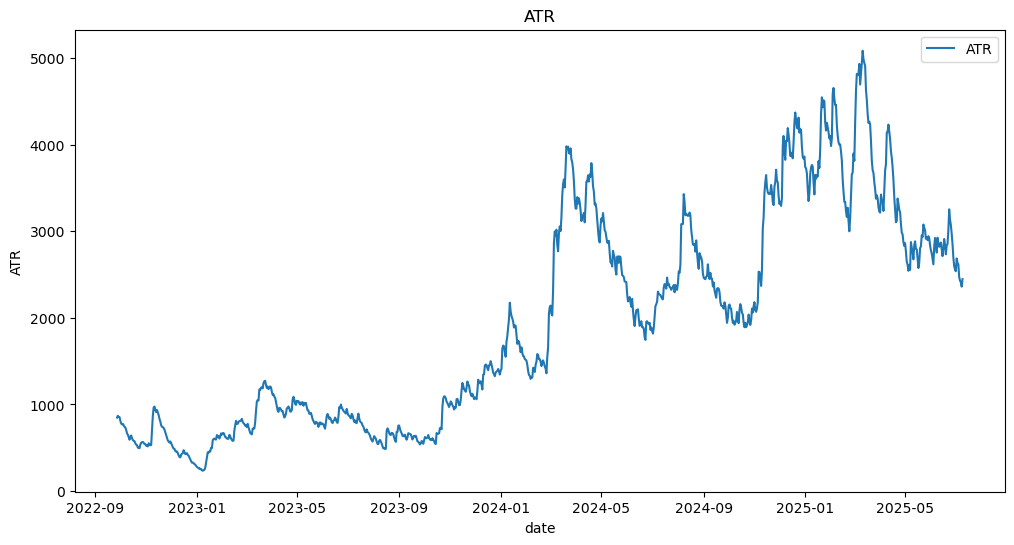

In [52]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['ATR'], label="ATR")
plt.title('ATR') 
plt.xlabel("date")
plt.ylabel("ATR") 
plt.legend() 
plt.show()

Видно как ATR(дневной диапозон движения цены) вырос за 2 года


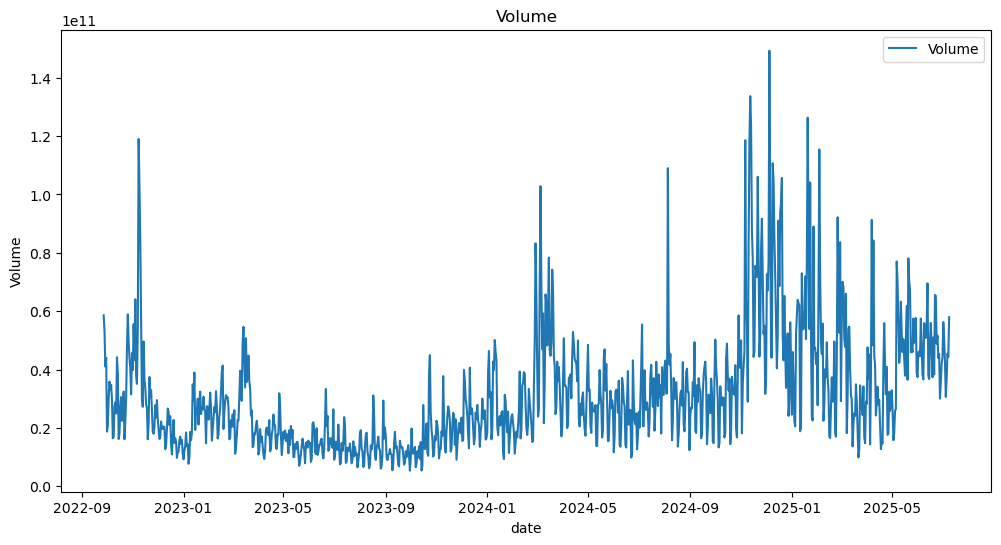

In [54]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['Volume'], label="Volume")
plt.title('Volume') 
plt.xlabel("date")
plt.ylabel("Volume") 
plt.legend() 
plt.show()

А вот объёмы выросли не так сильно(в 2-3 раза навскидку), ну если не брать всплески конца 24 года

обучение моделей. Для начала соберу baseline

In [57]:
split_idx = int(len(X) * 0.8)
X_train_base, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_base, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [58]:
#Параметры кросс-валидации 
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [59]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=100, random_state=42, class_weight='balanced')
)

In [60]:
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'precision': 'average_precision'
}
cv_res = cross_validate(clf, X_train_base, y_train_base, cv=tscv, scoring=scoring, return_train_score=False)
print({k: np.mean(v) for k,v in cv_res.items() if k.startswith('test_')})


{'test_accuracy': 0.9318518518518518, 'test_f1': 0.4473847720906544, 'test_roc_auc': nan, 'test_precision': 0.6366451314382331}


E:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\metrics\_rank

In [61]:
clf.fit(X_train_base, y_train_base)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Защита от ситуации "все метки в y_test одинаковы"
if len(np.unique(y_test)) < 2:
    print("В y_test только один класс — roc_auc/average_precision считать бессмыслено.")
else:
    roc_auc = metrics.roc_auc_score(y_test, y_prob)
    precision = metrics.average_precision_score(y_test, y_prob)

In [62]:
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print(f'Final on holdout: accuracy={accuracy:.3f}, f1={f1:.3f}, roc_auc={roc_auc:.3f}, precision={precision:.3f}')

Final on holdout: accuracy=0.956, f1=0.780, roc_auc=0.997, precision=0.973


In [63]:
scaler = StandardScaler()

In [64]:
smote = SMOTE(random_state=42, sampling_strategy='auto')

In [65]:
#Списки для сбора результатов 
fold_results = []
all_y_test = []
all_y_pred = []
all_y_proba = []

Обучу модели используя GridSearch для выявления лучших параметров

In [67]:
clf_grid_lr = LogisticRegression()
clf_grid_rf = RandomForestClassifier()
clf_grid_xgb = XGBClassifier()

In [68]:
comparison_df_data = []
all_models_results = {}

In [69]:
# --- Инициализация моделей для сравнения ---
models = {
    'LogisticRegression': LogisticRegression(), 
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier() 
}

In [70]:
#Цикл по каждой модели
for model_name, model_instance in models.items():
    print(f"\n Обучение и оценка модели: {model_name}")
    fold_metrics = []
    
    # Списки для общей ROC-кривой и PR-кривой для текущей модели (храним как списки фолдов)
    model_all_y_test_folds = []
    model_all_y_proba_folds = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"\nFold {fold+1}/{n_splits} для {model_name}")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 1. Масштабирование признаков
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        # 2.Применение SMOTE (толко на обучающем наборе)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

        print(f"Размер обучающего набора после SMOTE: {len(X_train_resampled)} строк")
        print(f"Распределение классов в обучающем наборе после SMOTE:\n{y_train_resampled.value_counts(normalize=True)}")

        # 3. Обучение модели
        model_instance.fit(X_train_resampled, y_train_resampled)

        # 4. Прогнозирование
        y_pred = model_instance.predict(X_test_scaled)
        y_proba = model_instance.predict_proba(X_test_scaled)[:, 1]

        # 5. Оценка метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        roc_auc = np.nan
        if len(np.unique(y_test)) == 2:
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            print(f"Внимание: Для Fold {fold+1} в тестовом наборе присутствует только один класс. ROC AUC не может быть вычислен.")

        print(f"Результаты для Fold {fold+1} ({model_name}):")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

        fold_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc})
        
        model_all_y_test_folds.append(y_test.tolist()) 
        model_all_y_proba_folds.append(y_proba.tolist()) # Сохраняем y_proba для этого фолда

    all_models_results[model_name] = {
        'fold_metrics': fold_metrics,
        'all_y_test_folds': model_all_y_test_folds, # Список списков для каждого фолда
        'all_y_proba_folds': model_all_y_proba_folds # Список списков для каждого фолда
    }


 Обучение и оценка модели: LogisticRegression

Fold 1/5 для LogisticRegression
Размер обучающего набора после SMOTE: 298 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Результаты для Fold 1 (LogisticRegression):
Accuracy: 0.9822, Precision: 0.9091, Recall: 0.8333, F1-Score: 0.8696, ROC AUC: 0.9952

Fold 2/5 для LogisticRegression
Размер обучающего набора после SMOTE: 612 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0    0.5
Name: proportion, dtype: float64
Внимание: Для Fold 2 в тестовом наборе присутствует только один класс. ROC AUC не может быть вычислен.
Результаты для Fold 2 (LogisticRegression):
Accuracy: 0.9763, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC AUC: nan

Fold 3/5 для LogisticRegression
Размер обучающего набора после SMOTE: 950 строк
Распределение классов в обучающем наборе после SMOTE:
Target_Volatility_Spike
1    0.5
0  

In [71]:
for model_name, results in all_models_results.items():
    fold_metrics = results['fold_metrics']
    y_test_folds = results['all_y_test_folds'] # Получаем y_test для каждого фолда

    # Фильтрую фолды, где был позитивный класс в y_test
    conditional_folds_metrics = []
    for i, fold_res in enumerate(fold_metrics):
        # Проверяем, есть ли хотя бы один позитивный класс (1) в этом y_test
        if np.sum(np.array(y_test_folds[i]) == 1) > 0:
            conditional_folds_metrics.append(fold_res)

    if conditional_folds_metrics: # Если есть хоть один подходящий фолд
        avg_accuracy = np.mean([res['accuracy'] for res in conditional_folds_metrics])
        avg_precision = np.mean([res['precision'] for res in conditional_folds_metrics])
        avg_recall = np.mean([res['recall'] for res in conditional_folds_metrics])
        avg_f1 = np.mean([res['f1'] for res in conditional_folds_metrics])
        valid_roc_aucs = [res['roc_auc'] for res in conditional_folds_metrics if not np.isnan(res['roc_auc'])]
        avg_roc_auc = np.mean(valid_roc_aucs) if valid_roc_aucs else np.nan
    else: # Если ни одного подходящего фолда не найдено
        avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc = np.nan, np.nan, np.nan, np.nan, np.nan

    comparison_df_data.append({
        'Model': model_name,
        'Avg Accuracy': avg_accuracy,
        'Avg Precision': avg_precision,
        'Avg Recall': avg_recall,
        'Avg F1-Score': avg_f1,
        'Avg ROC AUC': avg_roc_auc
    })

Оберну собранные метрики в датафрейм

In [73]:
final_comparison_df = pd.DataFrame(comparison_df_data)

final_comparison_df_sorted = final_comparison_df.sort_values(by='Avg F1-Score', ascending=False)
best_model_name = final_comparison_df_sorted.iloc[0]["Model"]  
print(final_comparison_df_sorted.to_string(index=False))

                 Model  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  Avg ROC AUC
         XGBClassifier      0.957101       0.787723    0.875000      0.828766     0.979563
    LogisticRegression      0.937870       0.769652    0.753472      0.732009     0.977375
RandomForestClassifier      0.930473       0.434874    0.458333      0.445055     0.973604


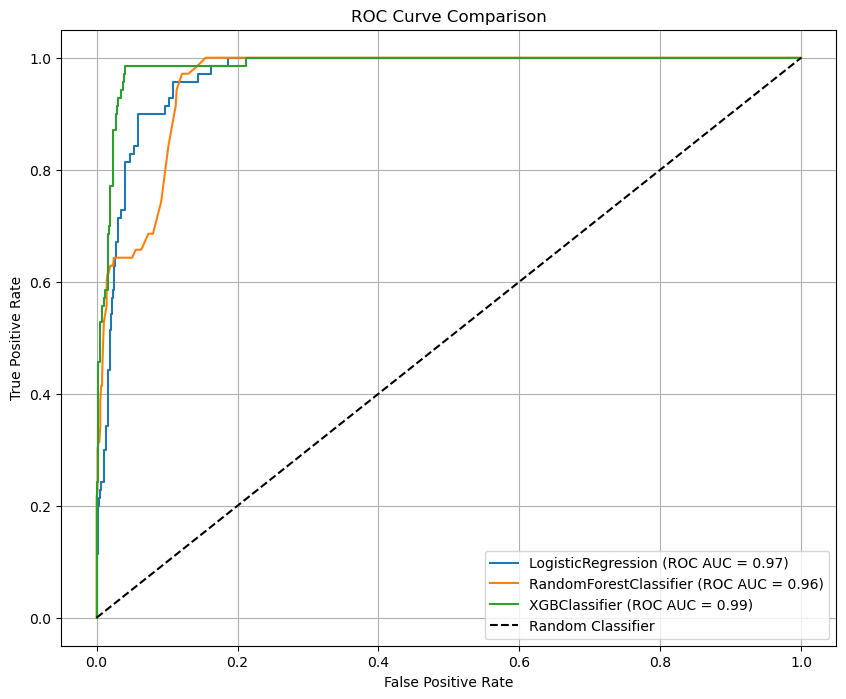

In [74]:
# Построение общей ROC-кривой для каждой модели 
plt.figure(figsize=(10, 8))
for model_name, results in all_models_results.items():
    # Сплющиваем списки списков в один плоский список для построения кривых
    y_true_combined = [item for sublist in results['all_y_test_folds'] for item in sublist]
    y_proba_combined = [item for sublist in results['all_y_proba_folds'] for item in sublist]

    fpr, tpr, _ = roc_curve(y_true_combined, y_proba_combined)
    overall_auc = roc_auc_score(y_true_combined, y_proba_combined)
    plt.plot(fpr, tpr, label=f'{model_name} (ROC AUC = {overall_auc:.2f})')
  

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

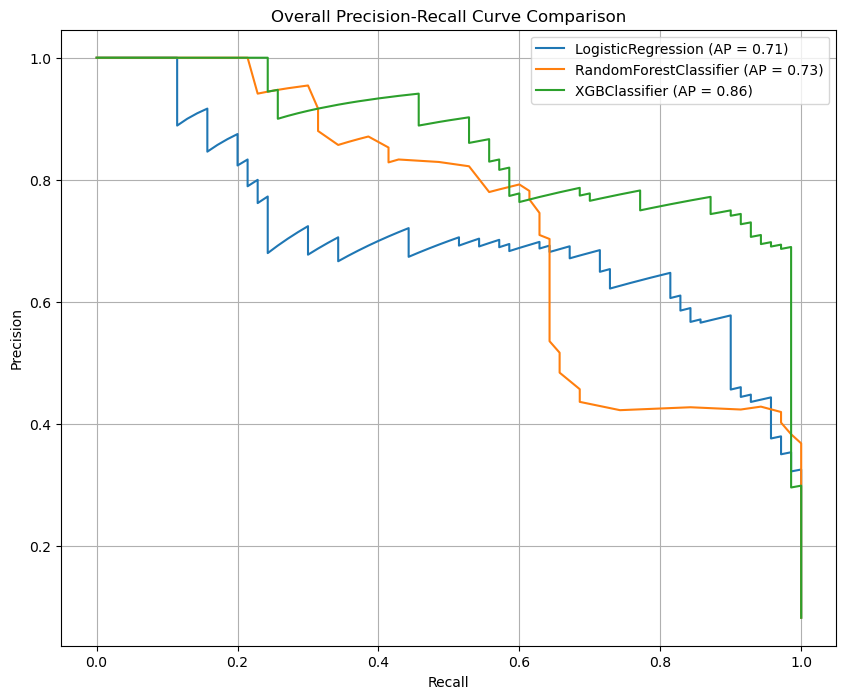

                 Model  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  Avg ROC AUC
         XGBClassifier      0.957101       0.787723    0.875000      0.828766     0.979563
    LogisticRegression      0.937870       0.769652    0.753472      0.732009     0.977375
RandomForestClassifier      0.930473       0.434874    0.458333      0.445055     0.973604


In [75]:
#Построение общей Precision-Recall кривой для каждой модели
plt.figure(figsize=(10, 8))
for model_name, results in all_models_results.items():
    y_true_combined = [item for sublist in results['all_y_test_folds'] for item in sublist]
    y_proba_combined = [item for sublist in results['all_y_proba_folds'] for item in sublist]

    precision_curve, recall_curve, _ = precision_recall_curve(y_true_combined, y_proba_combined)
    from sklearn.metrics import average_precision_score
    avg_precision_score = average_precision_score(y_true_combined, y_proba_combined)
    plt.plot(recall_curve, precision_curve, label=f'{model_name} (AP = {avg_precision_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()
print(final_comparison_df_sorted.to_string(index=False))

In [76]:
# Собираем все y_true и y_proba для лучшей модели
y_true_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_test_folds'] for item in sublist]
y_proba_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_proba_folds'] for item in sublist]
y_pred_best_combined = (np.array(y_proba_best_combined) > 0.5).astype(int) # Используем порог 0.5


In [77]:
cm = confusion_matrix(y_true_best_combined, y_pred_best_combined)

Дополнительно взгляну на TP, FP, TN, FN

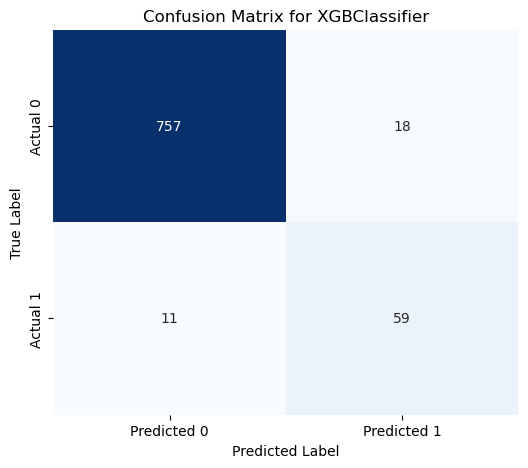

In [79]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [80]:
# Получим индексы для всех тестовых фолдов
all_test_indices = []
for train_idx, test_idx in tscv.split(X): # tscv был определен ранее
    all_test_indices.extend(X.iloc[test_idx].index.tolist())
# Убедимся, что индексы уникальны и отсортированы, если они могут повторяться
unique_sorted_test_indices = sorted(list(set(all_test_indices)))    

In [81]:
# Сплющиваем y_true и y_proba для лучшей модели
y_true_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_test_folds'] for item in sublist]
y_proba_best_combined = [item for sublist in all_models_results[best_model_name]['all_y_proba_folds'] for item in sublist]

In [82]:
# Создам Series с правильными индексами
y_true_series = pd.Series(y_true_best_combined, index=unique_sorted_test_indices)
y_proba_series = pd.Series(y_proba_best_combined, index=unique_sorted_test_indices)

prediction_threshold = 0.5 
y_pred_series = (y_proba_series > prediction_threshold).astype(int)

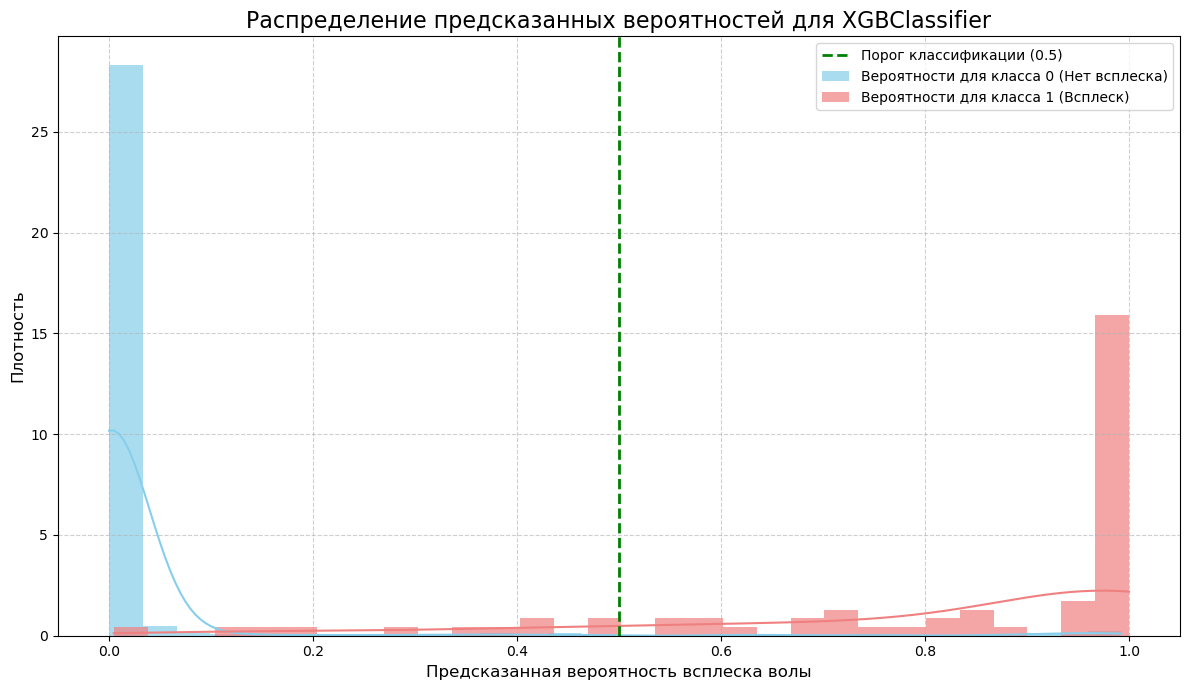

In [83]:
# --- 2. График: Распределение предсказанных вероятностей ---

plt.figure(figsize=(12, 7)) # Увеличиваем размер для лучшей читаемости
sns.histplot(y_proba_series[y_true_series == 0], color='skyblue', label='Вероятности для класса 0 (Нет всплеска)',
             kde=True, stat="density", linewidth=0, alpha=0.7, bins=30) # Увеличил количество бинов для детализации
sns.histplot(y_proba_series[y_true_series == 1], color='lightcoral', label='Вероятности для класса 1 (Всплеск)',
             kde=True, stat="density", linewidth=0, alpha=0.7, bins=30) # Увеличил количество бинов для детализации
plt.axvline(prediction_threshold, color='green', linestyle='--', linewidth=2, label=f'Порог классификации ({prediction_threshold})')
plt.title(f'Распределение предсказанных вероятностей для {best_model_name}', fontsize=16)
plt.xlabel('Предсказанная вероятность всплеска волы', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

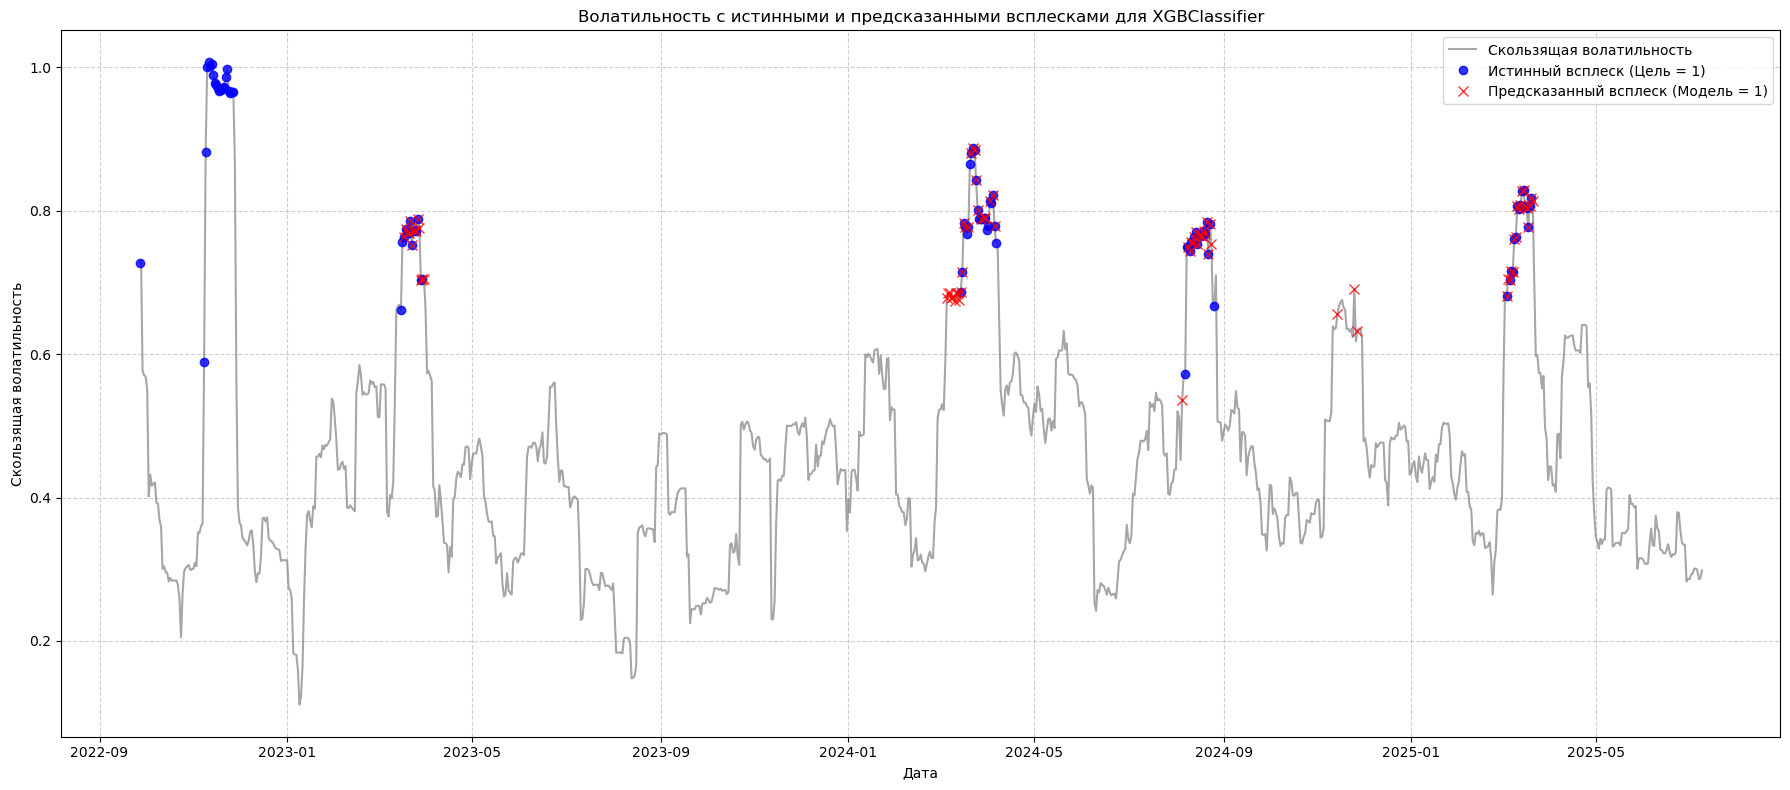

In [84]:
if 'Rolling_Volatility' in df.columns:
    plt.figure(figsize=(18, 8))

    # График общей волатильности
    plt.plot(df.index, df['Rolling_Volatility'], color='grey', alpha=0.7, label='Скользящая волатильность')

    # Отмечаем истинные всплески волатильности
    true_spikes_df = df[df['Target_Volatility_Spike'] == 1]
    if not true_spikes_df.empty:
        plt.plot(true_spikes_df.index, df.loc[true_spikes_df.index, 'Rolling_Volatility'], 'o', color='blue', markersize=6, label='Истинный всплеск (Цель = 1)', alpha=0.8)

    # Отмечаем предсказанные всплески волатильности на основе y_pred_series
    predicted_spikes_df = df.loc[y_pred_series[y_pred_series == 1].index]
    if not predicted_spikes_df.empty:
        plt.plot(predicted_spikes_df.index, df.loc[predicted_spikes_df.index, 'Rolling_Volatility'], 'x', color='red', markersize=7, label='Предсказанный всплеск (Модель = 1)', alpha=0.8)

    plt.title(f'Волатильность с истинными и предсказанными всплесками для {best_model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Скользящая волатильность')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Колонка 'Rolling_Volatility' не найдена в DataFrame для построения дополнительного графика.")

Модель довольно неплохо предсказывает всплеск волатильности. Думаю имеет смысл поиграть с порогом отнесения к классу, это могло бы положительно повлиять на метрики

In [86]:
prediction_threshold = 0.5
y_pred_series = (y_proba_series > prediction_threshold).astype(int)

In [87]:
from sklearn.inspection import permutation_importance

Top features by permutation importance (roc_auc):
                              feature  importance_mean  importance_std
             Rolling_Volatility_lag_1         0.008769        0.003612
             Rolling_Volatility_lag_2         0.006781        0.002690
             Rolling_Volatility_lag_3         0.003336        0.001863
                            MACD_Diff         0.003254        0.002369
                                 MACD         0.002601        0.002484
                 Vol_Ratio_Short_Long         0.001593        0.001083
                          MACD_Signal         0.001307        0.001541
             Rolling_Volatility_lag_5         0.000953        0.000748
                        Volume_lag_10         0.000940        0.001576
                    Daily_Range_Ratio         0.000926        0.001101
                     Close_Open_Ratio         0.000803        0.000573
                           BB_Percent         0.000790        0.001465
Rolling_Volatility_Daily_Ch

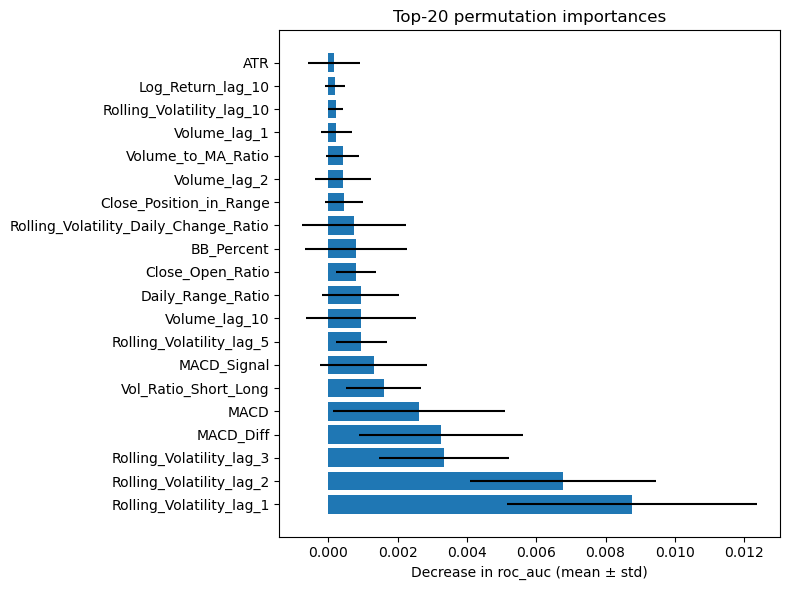

In [88]:
top_n = 20        # сколько топ-признаков показывать
n_repeats = 30
random_state = 42

if hasattr(X_test, "columns"):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])

res = permutation_importance(
    clf,
    X_test_df,
    y_test,
    n_repeats=n_repeats,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_test_df.columns,
    "importance_mean": res.importances_mean,
    "importance_std": res.importances_std
}).sort_values("importance_mean", ascending=False)


print("Top features by permutation importance (roc_auc):")
print(imp_df.head(top_n).to_string(index=False))

plot_df = imp_df.head(top_n).sort_values("importance_mean", ascending=True)
plt.figure(figsize=(8, max(4, 0.3 * len(plot_df))))
plt.barh(plot_df["feature"], plot_df["importance_mean"], xerr=plot_df["importance_std"])
plt.xlabel("Decrease in roc_auc (mean ± std)")
plt.title(f"Top-{len(plot_df)} permutation importances")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Все значения довольно маленькие, максимум 0.008 по roc-auc, это говорит, что данные очень шумные, что конечно же так.
Самые важные признаки - Rolling_Volatility_lag_1/2/3. Что тоже вполне понятно -> на высокую волатильность завтра влияет высокая волатильность сегодня/вчера/позавчера.

MACD отражает моментум (разницу между короткой и длинной скользящей средней).Видимо, моменты ускорения/замедления цены немного помогают прогнозировать всплески.

ATR, Log_Return_lag_10, Volume_lag_1, KC_* и прочие не помогают модели улучшать auc. Я думаю их можно было бы выкинуть

Я думаю в дальнейшем можно было бы оставить только самые важные( топ 10 признаков). и пытаться улучашть модель на их основе. Или же поступить более радикально, убрав полностью фичи, связанные с волатильностью. Но есть подозрение, что это только испортит результат, результаты будут еще более "шумные"/
